## Import Model to fine tune: CodeBERT

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")

batch_size = 8
num_epochs = 10
learning_rate = 1e-5
weight_decay = 0.05
class_weights = torch.tensor([1.9, 0.68])

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

## Create the Classification Head

In [ ]:
class CodeBERTForVulnDetection(nn.Module):
  def __init__(self, codebert):
    super(CodeBERTForVulnDetection, self).__init__()

    self.codebert = codebert
    self.dropout1 = nn.Dropout(p=0.2)
    self.linear1 = nn.Linear(768, 3072)
    self.tanh = nn.Tanh()
    self.dropout2 = nn.Dropout(p=0.2)
    self.linear2 = nn.Linear(3072, 3072)
    self.classifier = nn.Linear(3072, 2)

    self.loss_func = nn.BCEWithLogitsLoss(weight=class_weights)

  def forward(self, input_ids, attention_mask):
    # codeBERT output pooled
    output = self.codebert(input_ids = input_ids, attention_mask = attention_mask)
    output = torch.mean(output.last_hidden_state, 1)

    # classification head (https://arxiv.org/pdf/2204.03214.pdf, Table 4)
    output = self.dropout1(output)
    output = self.linear1(output)
    output = self.tanh(output)
    output = self.dropout2(output)
    output = self.linear2(output)
    output = self.classifier(output)

    return output

## Import Dataset & Implement dataset class

In [ ]:
!wget https://raw.githubusercontent.com/CGCL-codes/VulDeePecker/master/CWE-119/CGD/cwe119_cgd.txt

--2023-12-13 09:25:20--  https://raw.githubusercontent.com/CGCL-codes/VulDeePecker/master/CWE-119/CGD/cwe119_cgd.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17202057 (16M) [text/plain]
Saving to: ‘cwe119_cgd.txt’

cwe119_cgd.txt      100%[===================>]  16.40M  --.-KB/s    in 0.1s    

2023-12-13 09:25:20 (114 MB/s) - ‘cwe119_cgd.txt’ saved [17202057/17202057]



In [ ]:
from torch.utils.data import Dataset, DataLoader
import hashlib

# remove duplicates and conflicting labels
def clean_data(text_samples, labels):
  hashmap = {}
  blacklist = []

  for i in range(len(text_samples)):
    sample_digest = hashlib.sha256(text_samples[i].encode('utf-8')).hexdigest()

    if hashmap.get(sample_digest) == None:
      hashmap[sample_digest] = (labels[i], i)
    else:
      if hashmap[sample_digest][0] != labels[i] and (sample_digest not in blacklist):
        blacklist.append(sample_digest)

  for blacklisted_sample in blacklist:
    hashmap.pop(blacklisted_sample)

  values = hashmap.values()

  cleaned_samples = [text_samples[val[1]] for val in values]
  cleaned_labels = [labels[val[1]] for val in values]

  return cleaned_samples, cleaned_labels

class VulDeePeckerDataset(Dataset):
  def __init__(self, file_name, tokenizer):
    self.tokenizer = tokenizer

    # open file and process raw data
    raw_data = ""
    with open(file_name) as f:
      raw_data = f.read()

    raw_data = raw_data.split("---------------------------------\n")

    self.samples = []
    self.labels = []

    # seperate samples from labels and eliminate empty entries
    for sample in raw_data:
      sample = sample.strip().split("\n")[1:]

      if len(sample) < 3:
        continue

      self.samples.append("\n".join(sample[:-1]))
      self.labels.append(int(sample[-1]))

    # Clean Data
    self.samples, self.labels = clean_data(self.samples, self.labels)

    # Tokenize samples
    self.samples = self.tokenizer(self.samples, padding=True, truncation=True, return_tensors='pt', max_length=512)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = torch.tensor([self.labels[idx], 1 - self.labels[idx]], dtype=torch.float32)
    return self.samples["input_ids"][idx].squeeze(), self.samples["attention_mask"][idx].squeeze(), label

In [ ]:
dataset = VulDeePeckerDataset("cwe119_cgd.txt", tokenizer)
print("Full data-set size:", len(dataset))

Full data-set size: 19904


In [ ]:
dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = dataset[0]
test_dataset = dataset[1]
validation_dataset = dataset[2]
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))
print("Validation size:", len(validation_dataset))

Train size: 15924
Test size: 1990
Validation size: 1990


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = CodeBERTForVulnDetection(codebert_model)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Simple plotting function

In [ ]:
import matplotlib.pyplot as plt

def simple_plot(x_axis, y_axis, x_label, y_label, title):
  plt.plot(x_axis, y_axis)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.grid()
  plt.show()

## Model Evaluation Function

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from collections import namedtuple

# Evaluate model
def evaluate(dataloader):
  model.eval()

  all_labels = []
  all_predictions = []

  with torch.no_grad():
    for input_ids, attention_mask, labels in dataloader:
        # transfer to GPU if available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model.forward(input_ids, attention_mask)

        # find predictions and truths to calculate confusion matrix
        all_labels += torch.min(labels.cpu(), dim=1).indices.tolist()
        all_predictions += torch.min(outputs.cpu(), dim=1).indices.tolist()

  # evaluation scores
  cm = confusion_matrix(all_labels, all_predictions)
  accuracy = accuracy_score(all_labels, all_predictions)
  precision = precision_score(all_labels, all_predictions)
  recall = recall_score(all_labels, all_predictions)
  f1 = f1_score(all_labels, all_predictions)

  # Calculate false positive rate (FPR) and false negative rate (FNR)
  tn, fp, fn, tp = cm.ravel()
  fpr = fp / (fp + tn)
  fnr = fn / (fn + tp)

  # Create a named tuple to return values
  RetType = namedtuple("RetType", ["accuracy", "precision", "recall", "f1_score", "fpr", "fnr"])

  return RetType(accuracy, precision, recall, f1, fpr, fnr)


In [ ]:
# untrained model evaluation
evaluate(test_dataloader)

RetType(accuracy=0.44321608040201005, precision=0.406479217603912, recall=0.8291770573566085, f1_score=0.5455291222313372, fpr=0.8173400673400674, fnr=0.1708229426433915)

## Model Training

Mounted at /content/drive
Epoch: 1, Progress: 15928/15924;100.03%, Loss Avg: 0.31811176090335075, Current Batch Loss: 0.00296155852265656
Epoch 1 performance metrics:
Accuracy: 0.9382
Precision: 0.9594
Recall: 0.8840
F1 Score: 0.9202
False Positive Rate: 0.0253
False Negative Rate: 0.1160


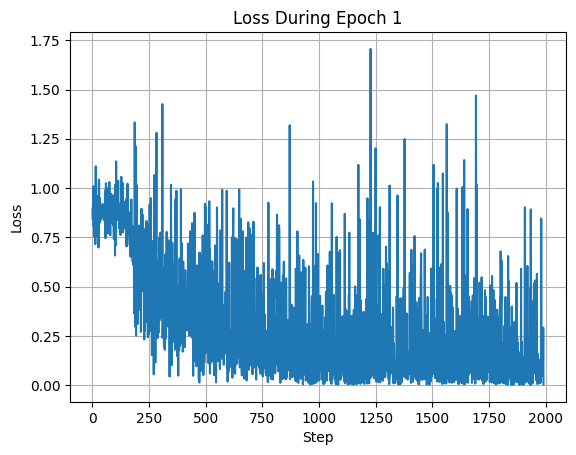

Epoch: 2, Progress: 15928/15924;100.03%, Loss Avg: 0.1332837234300229, Current Batch Loss: 0.3877989649772644
Epoch 2 performance metrics:
Accuracy: 0.9583
Precision: 0.9499
Recall: 0.9464
F1 Score: 0.9482
False Positive Rate: 0.0337
False Negative Rate: 0.0536


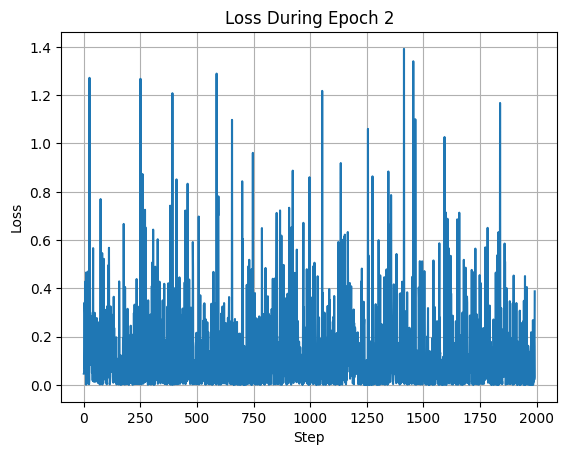

Epoch: 3, Progress: 15928/15924;100.03%, Loss Avg: 0.10290238993545232, Current Batch Loss: 0.15646982192993164
Epoch 3 performance metrics:
Accuracy: 0.9623
Precision: 0.9538
Recall: 0.9526
F1 Score: 0.9532
False Positive Rate: 0.0311
False Negative Rate: 0.0474


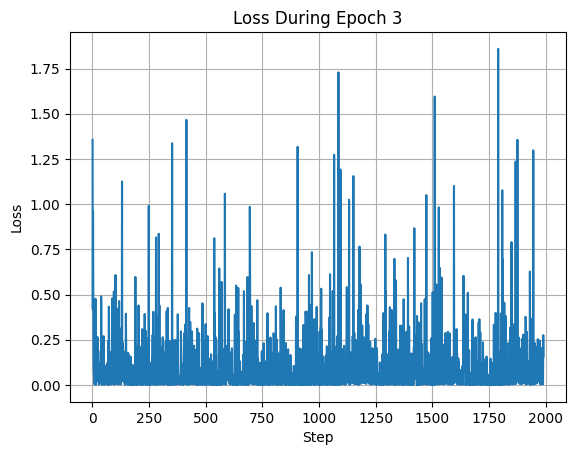

Epoch: 4, Progress: 4560/15924;28.64%, Loss Avg: 0.07932083448456405, Current Batch Loss: 0.010578247718513012

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files, drive

drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/CyberGuardModel"

# train model
def train():
  loss_values = []
  for epoch in range(num_epochs):
    model.train()

    loss_values.append([])
    batch_count = 0

    # iterate over batches
    for input_ids, attention_mask, labels in train_dataloader:
      # transfer to GPU if available
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)

      # forward pass
      outputs = model.forward(input_ids, attention_mask)

      # calculate loss
      loss = model.loss_func(outputs, labels)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # console info
      batch_count += 1
      loss_values[epoch].append(loss.item())

      print("\rEpoch: {}, Progress: {}/{};{:.2f}%, Loss Avg: {}, Current Batch Loss: {}".format(epoch + 1, batch_count * batch_size, len(train_dataset), ((batch_count*batch_size)/len(train_dataset))*100, sum(loss_values[epoch])/len(loss_values[epoch]), loss.item()), end="")

    # Evaluate epoch performance
    print("\nEvaluating Epoch Performance...", end="")
    eval_result = evaluate(test_dataloader)
    print("\rEpoch {} performance metrics:\nAccuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}\nFalse Positive Rate: {:.4f}\nFalse Negative Rate: {:.4f}".format(
        epoch + 1,
        eval_result.accuracy,
        eval_result.precision,
        eval_result.recall,
        eval_result.f1_score,
        eval_result.fpr,
        eval_result.fnr
    ))

    # Plot Loss This Epoch
    simple_plot(list(range(1, len(loss_values[epoch]) + 1, 1)), loss_values[epoch], 'Step', 'Loss', 'Loss During Epoch {}'.format(epoch + 1))

    # Save model with epoch number
    torch.save(model.state_dict(), '/content/drive/My Drive/CyberGuardModel/epoch{}_checkpoint.ckpt'.format(epoch+1))
    if (epoch+1) in [4,9]:
      files.download("/content/drive/My Drive/CyberGuardModel/epoch{}_checkpoint.ckpt".format(epoch+1))

  # Plot Loss over time
  print("Done Training.")
  y_axis = []
  for l in loss_values:
    y_axis += l
  x_axis = list(range(1, len(y_axis) + 1, 1))
  simple_plot(x_axis, y_axis, 'Step', 'Loss', 'Loss During Training')

train()

In [ ]:
files.download("epoch10_checkpoint.ckpt")